In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
from utils.genprodUtils.generators import Generator
from utils.genprodUtils.kinematics import two_body_decay, random_decay

class Signal(Generator):

    def __init__(self, m_x, m_y):
        assert m_x > 2 * m_y , "m_x must be greater than 2 * m_y"
        self.m_x , self.m_y = m_x, m_y

        super().__init__(
            dict(
                pt=lambda n : np.random.lognormal(np.log(100), 1, n),
                eta=lambda n : np.random.uniform(-2.5, 2.5, n),
                phi=lambda n : np.random.uniform(-np.pi, np.pi, n),
                mass=lambda n : np.random.normal(m_x, 0.1*m_x, n),
            )
        )

    def valid(self, event):
        self.y = np.random.lognormal( np.log(self.m_y), 0.2, size=(len(event), 2) )
        self.j = np.random.lognormal( np.log(10), 0.5, size=(len(event), 2, 2) )
        mask = (event.mass > np.sum(self.y, axis=1)) & np.all( self.y > np.sum(self.j, axis=-1), axis=1 )

        self.y = self.y[mask]
        self.j = self.j[mask]

        return mask

    
    def physics(self, event):
        y1, y2 = two_body_decay(event, *self.y.T)

        y1j1, y1j2 = two_body_decay(y1, *self.j[:,0].T)
        y2j1, y2j2 = two_body_decay(y2, *self.j[:,1].T)

        jet = ak.concatenate([ j[:,None] for j in [y1j1, y1j2, y2j1, y2j2] ], axis=1)
        jet = jet[ak.argsort(-jet.pt, axis=1)]

        return dict(
            jet=jet,
            y1=y1,
            y2=y2,
        )

In [3]:
class Background(Generator):
    def __init__(self):
        super().__init__(
            dict(
                pt=lambda n : np.random.lognormal(np.log(100), 1, n),
                eta=lambda n : np.random.uniform(-2.5, 2.5, n),
                phi=lambda n : np.random.uniform(-np.pi, np.pi, n),
                mass=lambda n : np.random.lognormal( np.log(400), 1, n),
            )
        )

    def valid(self, event):
        self.y = np.random.lognormal( np.log(50), 1, size=(len(event), 2) )
        self.j = np.random.lognormal( np.log(10), 0.5, size=(len(event), 2, 2) )
        mask = (event.mass > np.sum(self.y, axis=1)) & np.all( self.y > np.sum(self.j, axis=-1), axis=1 )

        self.y = self.y[mask]
        self.j = self.j[mask]

        return mask

    def physics(self, event):
        y1, y2 = two_body_decay(event, *self.y.T)

        y1j1, y1j2 = two_body_decay(y1, *self.j[:,0].T)
        y2j1, y2j2 = two_body_decay(y2, *self.j[:,1].T)

        jet = ak.concatenate([ j[:,None] for j in [y1j1, y1j2, y2j1, y2j2] ], axis=1)
        jet = jet[ak.argsort(-jet.pt, axis=1)]

        return dict(
            jet=jet,
            y1=y1,
            y2=y2,
        )

In [4]:
masses = [(400, 50)]
gen_sig = { mass:Signal(*mass) for mass in masses }

In [5]:
gen_bkg = Background()

In [6]:
gen_bkg.efficiency()

0.511

In [7]:
signal = ObjIter([ Tree.from_ak(gen(int( 5000 / len(gen_sig) )), sample=f'mass={m}', is_signal=True, mass=m) for m, gen in gen_sig.items() ])
bkg = ObjIter([ Tree.from_ak(gen_bkg(5000), sample='bkg', color='lightgrey') ])

0it [00:00, ?it/s]


[WARNING] unable to open any files with filelist
           []


0it [00:00, ?it/s]

[WARNING] unable to open any files with filelist
           []


100%|██████████| 4/4 [00:00<00:00, 25.89it/s]


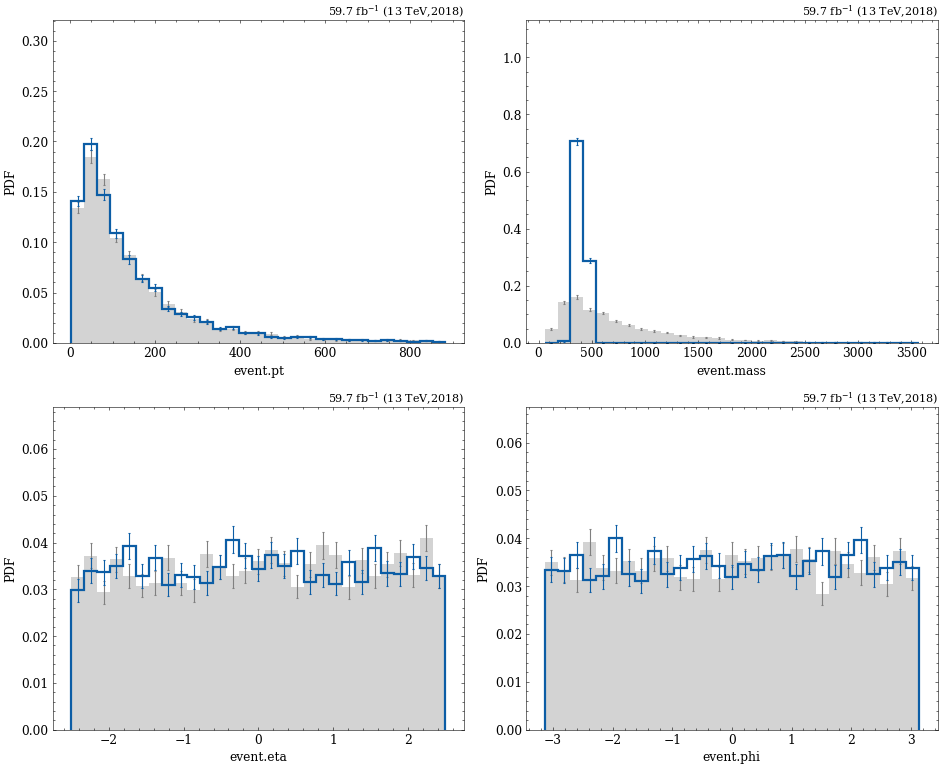

In [8]:
study.quick(
    signal + bkg,
    varlist=['event.pt','event.mass','event.eta','event.phi'],
    efficiency=True,
)

100%|██████████| 4/4 [00:00<00:00, 15.91it/s]


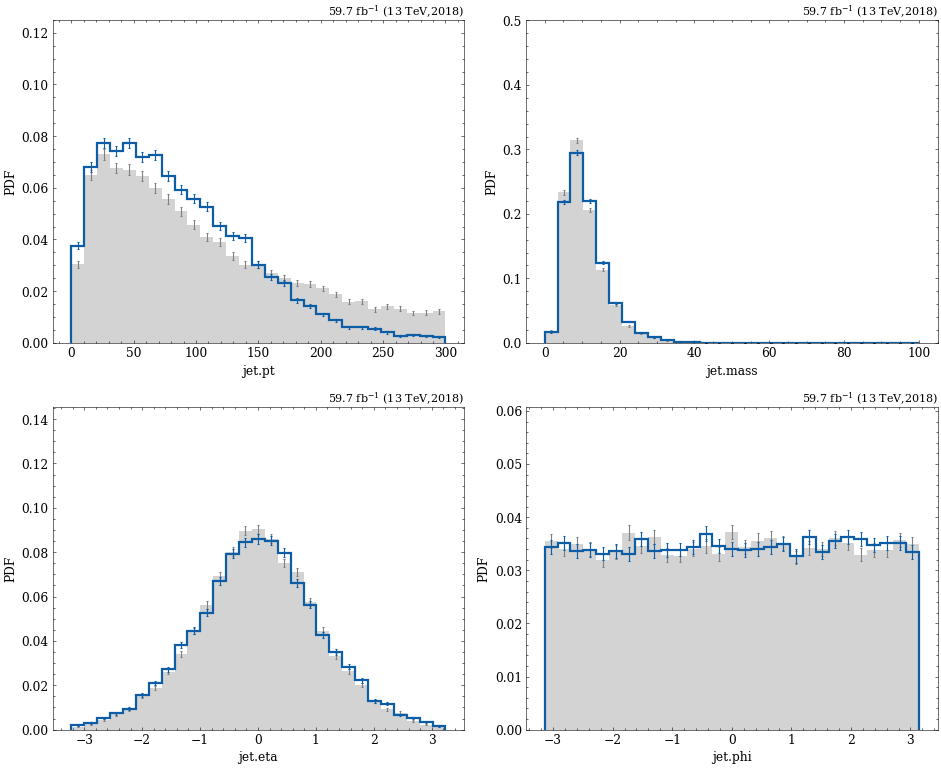

In [9]:
study.quick(
    signal + bkg,
    varlist=['jet.pt','jet.mass','jet.eta','jet.phi'],
    binlist=[(0,300,30),(0,100,30)],
    efficiency=True,
)

In [10]:
import torch

class Dataset(torch.utils.data.Dataset):
    def __init__(self, trees):
        self.trees = trees
        self.length = sum( len(tree) for tree in trees )

        self.inputs = np.concatenate([ self.get_inputs(tree) for tree in trees ], axis=0)
        self.targets = np.concatenate([ self.get_targets(tree) for tree in trees ], axis=0)

    @property
    def input_dims(self):
        return self.inputs.shape[1]

    def __getitem__(self, idx):
        return dict(
            inputs=self.inputs[idx],
            targets=self.targets[idx],
        )

    def __len__(self):
        return self.length

    def get_inputs(self, tree):
        feature_names = ['event.mass', 'event.pt',]
        features = list()

        for feature in feature_names:
            feature = tree[feature]
            if feature.ndim == 1:
                feature = feature[:,None]

            features.append(feature)

        features = ak.concatenate(features, axis=1).to_numpy().astype(np.float32)
        return features

    def get_targets(self, tree):
        return np.ones(len(tree), dtype=np.int64) * tree.is_signal
    
dataset = Dataset(signal + bkg)

In [11]:
loader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)
for batch in loader:
    break

In [12]:
import pytorch_lightning as pl
import torchmetrics

In [ ]:
class ClusterClassifier(pl.LightningModule):
    def __init__(self, input_dim, embedding_dims : list, hidden_dims : list, n_classes=2, n_clusters=2):
        super().__init__()

        self.input_dim = input_dim

        self.batch_norm = torch.nn.BatchNorm1d(input_dim, affine=False)

        embedding_dims = [input_dim] + embedding_dims
        input_embedding = []
        for n_in, n_out in zip(embedding_dims[:-1], embedding_dims[1:]):
            input_embedding += [torch.nn.Linear(n_in, n_out), torch.nn.ReLU()]
        self.input_embedding = torch.nn.Sequential(*input_embedding)

        self.cluster_embedding = torch.nn.Embedding(n_clusters, embedding_dims[-1])
        self.cluster_index = torch.nn.Parameter(torch.arange(n_clusters), requires_grad=False)

        hidden_dims = [embedding_dims[-1]] + hidden_dims + [n_classes]
        hidden = []
        for n_in, n_out in zip(hidden_dims[:-1], hidden_dims[1:]):
            hidden += [torch.nn.Linear(n_in, n_out), torch.nn.ReLU()]
        self.hidden = torch.nn.Sequential(*hidden[:-1])
        self.softmax = torch.nn.Softmax(dim=1)

        self.auroc = torchmetrics.AUROC('multiclass', num_classes=n_classes)

    def forward(self, x):
        x = self.batch_norm(x)
        x = self.input_embedding(x)

        c = self.cluster_embedding(self.cluster_index)
        chi2 = torch.mean((x[:,None] - c[None])**2, axis=-1)

        x = self.hidden(x)
        return self.softmax(x), chi2
    
    def training_step(self, batch, batch_idx):
        inputs, targets = batch['inputs'], batch['targets']
        probs, chi2 = self(inputs)

        nearest_cluster = torch.argmin(chi2, axis=1)
        return nearest_cluster, chi2


        loss = torch.nn.functional.cross_entropy(probs, targets)
        self.log('train_loss', loss, prog_bar=True, on_epoch=True, on_step=False)

        auroc = self.auroc(probs, targets)
        self.log('train_auroc', auroc, prog_bar=True, on_epoch=True, on_step=False)

        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [ ]:
model = ClusterClassifier(dataset.input_dims, [16, 32], [32, 16], n_classes=2, n_clusters=2)

In [ ]:
nc, chi2 = model.training_step(batch, 0)

In [ ]:
nc, chi2

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])

In [15]:
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model, loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type            | Params
------------------------------------------------------
0 | batch_norm        | BatchNorm1d     | 0     
1 | input_embedding   | Sequential      | 592   
2 | cluster_embedding | Embedding       | 64    
3 | hidden            | Sequential      | 1.6 K 
4 | softmax           | Softmax         | 0     
5 | auroc             | MulticlassAUROC | 0     
------------------------------------------------------
2.3 K     Trainable params
0         Non-trainable params
2.3 K     Total params
0.009     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
